# Logistic regression

## Introduction

Let $Y$ be a **dependent variable**, also called **response variable** or **predictor**, whose behaviour can be explained by the **independent variables** $X_1, X_2, \ldots, X_k$, also known as **explanatory variables** or **features**.

In classification, $Y$ is a binary variable belonging to either one of two classes, labeled as 0 or 1, although generalizations where $Y$ takes any (finite) number of outcomes exists.

Let $p = P(Y = 1)$, be the probability of $Y$ to belong to class 1. In logistic regression, the probability $p$ can be described as follows:
$$p = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 X_1 + \ldots + \beta_k X_k))}$$
where $\beta_0, \beta_1, \ldots, \beta_k$ are the model parameters and $\exp$ denotes the exponential function. The **log odds** of the dependent variable are defined as
$$\log\frac{p}{1 - p} = \beta_0 + \beta_1 X_1 + \ldots + \beta_k X_k$$

## The logistic function

The function
$$\sigma(t) = \frac{1}{1 + e^{-t}}$$
is known as the **logistic function** (and thus the name of logistic regression), and its inverse
$$\sigma^{-1}(p) = \log\frac{p}{1 - p}, \ 0 < p < 1$$
is known as the **logit function**.

To illustrate the model, lets sample a few points and plot both the sampled points and the logistic function.

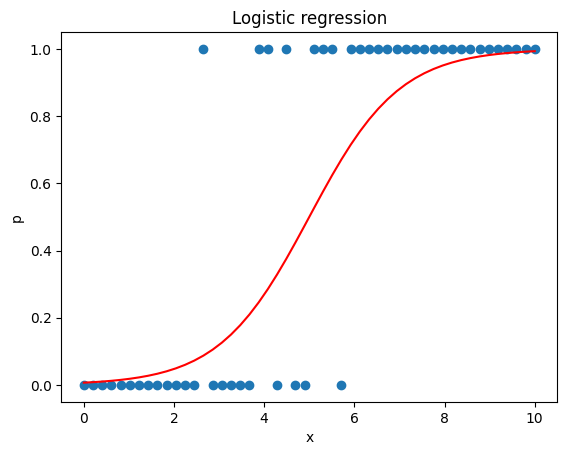

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=1000)
beta = [-5, 1]
x = np.linspace(0, 10)
p = 1/(1 + np.exp(-(beta[0] + beta[1]*x)))
y = rng.binomial(1, p, size=x.shape)

plt.figure()
plt.title("Logistic regression")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(x, y, "o")
plt.plot(x, p, "r-")
plt.show()

## Estimation

Let
* $\mathbf{y} = (y_1, \ldots, y_n)$ be the vector of observed dependent variables,
* $\mathbf{\beta} = (\beta_0, \beta_1, \ldots, \beta_k)$ be the vector of model parameters, and
* $\mathbf{X} = (x_{ij})$ be the matrix of observed independent variables, where each row $\mathbf{x}_i = (1, x_{i1}, \ldots, x_{ik})$ represents an observation and each column represents a feature. The first column of $\mathbf{X}$ is filled with ones and is the column corresponding to the intercept $\beta_0$.

Additionally, let
* $\mathbf{\mu}$ denote the vector whose $i$-th entry is $\mu_i = \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}$, and
* $W$ denote the diagonal matrix whose $i$-th diagonal entry is $w_{ii} = \left(\frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)\left(1 - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)$. 

The model parameters $\mathbf{\beta}$ can be estimated by applying the following iterative method:
1. Begin with an initial guess $\mathbf{\beta}^{(0)}$.
2. At each iteration:
    - Solve $\mathbf{X}^{\top}\mathbf{WX\gamma} = \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu})$ for $\mathbf{\gamma}$.
    - Set $\mathbf{\beta}^{(t + 1)} = \mathbf{\beta}^{(t)} + \mathbf{\gamma}$.

The method ends once the parameters stop changing, i.e. when $\mathbf{\beta}^{(t + 1)}$ is virtually the same as $\mathbf{\beta}^{(t)}$, or when a maximum number of iterations have been reached.

See [Maximum likelihood estimator](#maximum-likelihood-estimator) for the deduction of this method.

In [2]:
from numpy.linalg import solve, norm

X = np.column_stack((np.ones(x.shape), x))
with np.printoptions(precision=2, threshold=10, edgeitems=3):
    print("Matrix of observed independent variables:")
    print(X)
    print("Vector of observed dependent variables:")
    print(y)

beta_mle = [0, 0]
max_iter = 100
tol = 1e-4
for iter in range(max_iter):
    mu = 1/(1 + np.exp(-X @ beta_mle))
    W = np.diag(mu*(1 - mu))
    beta_incr = solve(X.T @ W @ X, X.T @ (y - mu))
    if norm(beta_incr) < tol:
        break
    beta_mle = beta_mle + beta_incr

print("Method converged in", iter, "iterations")
print("Estimator:")
print(beta_mle)

Matrix of observed independent variables:
[[ 1.    0.  ]
 [ 1.    0.2 ]
 [ 1.    0.41]
 ...
 [ 1.    9.59]
 [ 1.    9.8 ]
 [ 1.   10.  ]]
Vector of observed dependent variables:
[0 0 0 ... 1 1 1]
Method converged in 6 iterations
Estimator:
[-5.70921579  1.30169546]


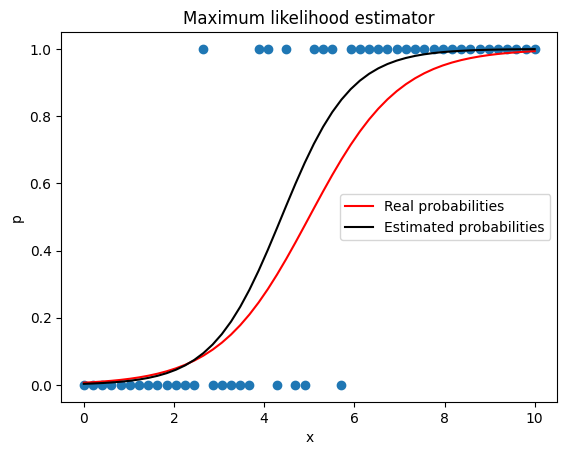

In [3]:
plt.figure()
plt.title("Maximum likelihood estimator")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(x, y, "o")
plt.plot(x, 1/(1 + np.exp(-(beta[0] + beta[1]*x))), "r-",
         label="Real probabilities")
plt.plot(x, 1/(1 + np.exp(-(beta_mle[0] + beta_mle[1]*x))), "k-",
         label="Estimated probabilities")
plt.legend()
plt.show()

### Senility and WAIS

A sample of elderly people was given a psychiatric examination to determine whether symptoms of senility were present. Other measurements taken at the same time included the score on a subset of the Wechsler Adult Intelligent Scale (WAIS). The data are shown in the following table:

In [4]:
import pandas as pd

df_wais = pd.read_csv("data/wais-scores.csv")
df_wais.head()

,score,senile
0,9,1
1,13,1
2,6,1
3,8,1
4,10,1


We have the following variables:
- *score* The WAIS scores.
- *senile* Symptoms of senility, 1 if symptoms are present and 0 otherwise.

We want to predict the probabilities of *senile* in terms of *score*.

In [5]:
n, _ = df_wais.shape
X = np.column_stack((np.ones(n), df_wais.score))
y = df_wais.senile

beta_mle = [0, 0]
max_iter = 100
tol = 1e-4
for iter in range(max_iter):
    mu = 1/(1 + np.exp(-X @ beta_mle))
    W = np.diag(mu*(1 - mu))
    beta_incr = solve(X.T @ W @ X, X.T @ (y - mu))
    if norm(beta_incr) < tol:
        break
    beta_mle = beta_mle + beta_incr

print("Method converged in", iter, "iterations")
print("Estimator:")
print(beta_mle)

Method converged in 4 iterations
Estimator:
[ 2.40400719 -0.32352604]


The maximum likelihood estimator for $\beta_0$ and $\beta_1$ are 2.40 and -0.32, respectively. This means that the log odds start at 2.40 and decreases in a rate of 0.32 units per score.

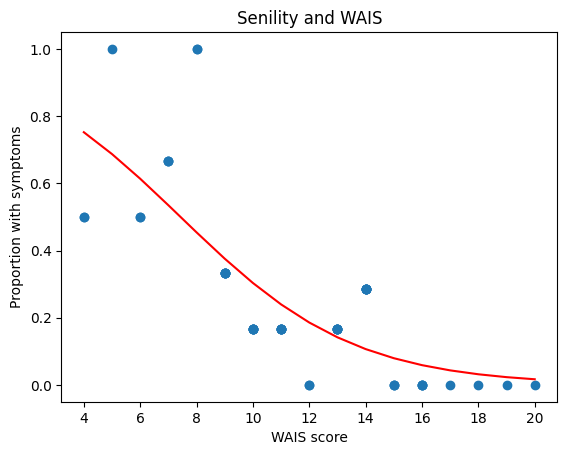

In [6]:
df_wais.sort_values(by="score", inplace=True)

df_wais["proportion"] = df_wais.groupby(by="score").senile.transform(np.mean)
df_wais["log_odds"] = beta_mle[0] + beta_mle[1]*df_wais.score
df_wais["fitted_prob"] = 1/(1 + np.exp(-df_wais.log_odds))

plt.figure()
plt.title("Senility and WAIS")
plt.xlabel("WAIS score")
plt.ylabel("Proportion with symptoms")
plt.plot("score", "proportion", "o", data=df_wais)
plt.plot("score", "fitted_prob", "r-", data=df_wais)
plt.show()

The previous plot compares the fitted probabilities against the proportion of people who presented symptoms of senility grouped by WAIS score. We can tell from the plot that the probability of presenting symptoms decreases as the scores increases. 

It is important to mention that the model only predicts the probability of presenting symptoms, it doesn't tell us whether a specific person will present symptoms or not. If we want a binary response, we can apply a threshold on the probability. For example, if the probability is above 0.50, i.e. when the WAIS score is below 8, the person is most likely to present symptoms.

## Cross entropy and other metrics

When we train a model, we want to measure in some way its performance. There are a couple of metrics that can be used for logistic regression.

- **Cross entropy loss**: The cross entropy loss is defined as the negative log-likelihood of Bernoulli distributed random variates divided by the number of samples
$$Loss(\mathbf{y}, p) = -\frac{1}{n}\sum_{i=1}^{n} (y_i\log p + (1 - y_i)\log(1 - p))$$

The logistic regression minimizes the cross entropy loss. Therefore, we will expect a small value in a good model.

- **Accuracy**: The accuracy score is defined as the proportion of labels predicted correctly
$$accuracy(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{n}\sum_{i=1}^{n}1(y_i = \hat{y}_i)$$
In the best case, the predicted labels match exactly the observed labels, so the accuracy is 1. In the worst case, no predicted label match the observed label, so the accuracy is 0.

In [7]:
loss = -np.mean(df_wais.senile * np.log(df_wais.fitted_prob) + 
                (1 - df_wais.senile) * np.log(1 - df_wais.fitted_prob))
print("Cross entropy loss:", loss)

df_wais["fitted_senile"] = np.where(df_wais.fitted_prob > 0.5, 1, 0)
accuracy = np.mean(df_wais.senile == df_wais.fitted_senile)
print("Accuracy:", accuracy)

Cross entropy loss: 0.47238314610779025
Accuracy: 0.7777777777777778


For our previous example, we have a cross entropy loss of 0.47 and an accuracy of 0.77. This means that 77% of the labels are predicted correctly.

### Confusion matrix

Let
- *TP* be the number of "1" labels correctly predicted as "1" (True Positive),
- *TN* be the number of "0" labels correctly predicted as "0" (True Negative),
- *FP* be the number of "0" labels incorrectly predicted as "1" (False Positive), and
- *FN* be the number of "1" labels incorrectly predicted as "0" (False Negative).

A **confusion matrix** is a table that allows to visualize the performance of a classifier. It contains the previous information as follows:

| True label \ Predicted label | **1**               | **0**               |
|------------------------------|---------------------|---------------------|
| **1**                        | True Positive (TP)  | False Negative (FN) |
| **0**                        | False Positive (FP) | True Negative (TN)  |

The confussion matrix is often accompanied with the following metrics:

- **Precision**: The precision score is defined as the number of true positives divided by the number of labels predicted as positve
$$precision = \frac{TP}{TP + FP}$$
The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- **Recall**: The recall score is defined as the number of true positives divided by the number of positive labels
$$recall = \frac{TP}{TP + FN}$$
The recall is intuitively the ability of the classifier to find all the positive samples.

- **F1-Score**: The F1 score is defined as the harmonic mean of the precision and recall
$$F1 = \frac{2 \times precision \times recall}{precision + recall}$$
In the best case, both precision and recall scores are 1, so the F1-score is also 1. In the worst case, either precision or recall scores are 0, so the F1-score is also 0.

In [8]:
TP = np.sum((df_wais.senile == 1) & (df_wais.fitted_senile == 1))
TN = np.sum((df_wais.senile == 0) & (df_wais.fitted_senile == 0))
FP = np.sum((df_wais.senile == 0) & (df_wais.fitted_senile == 1))
FN = np.sum((df_wais.senile == 1) & (df_wais.fitted_senile == 0))

precision = TP/(TP + FP)
recall = TP/(TP + FN)
F1 = 2*precision*recall/(precision + recall)

print("Confussion matrix")
print(np.array([[TP, FN], [FP, TN]]))
print("Precision:", precision)
print("Recall:", recall)
print("F1:", F1)

Confussion matrix
[[ 5  9]
 [ 3 37]]
Precision: 0.625
Recall: 0.35714285714285715
F1: 0.45454545454545453


For our previous example, we can tell by looking at the confusion matrix that out of 14 people who presented symptoms of senility, only 5 of them were predicted to present symptoms based on their WAIS score. Similarly, out of 40 who didn't present symptoms of senility, 37 of them were predicted to not present symptoms based on their WAIS score.

On the other hand, we have a precision score of 0.62 and a recall score of 0.35. This means that only 62% of the people predicted to present symptoms actually presented symptoms. Similarly, only 35% of the people who presented symptoms were predicted to present symptoms.

## Multiple features

### Iris dataset

The following table contains 2 classes of 50 instances each, where each class refers to a type of iris plant:

In [9]:
df_iris = pd.read_csv("data/iris.csv")
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,7.0,3.2,4.7,1.4,1
1,6.4,3.2,4.5,1.5,1
2,6.9,3.1,4.9,1.5,1
3,5.5,2.3,4.0,1.3,1
4,6.5,2.8,4.6,1.5,1


We have the following variables:
- *sepal_length* The sepal length in cm.
- *sepal_width* The sepal width in cm.
- *petal_length* The petal length in cm.
- *petal_width* The petal width in cm.
- *species* Type of iris plant, 1 for *Iris-versicolor* and 0 for *Iris-virginica*.

We want to predict the probabilities of *species* in terms of *sepal_length*, *sepal_width*, *petal_length* and *petal_width*.

In [10]:
n, _ = df_iris.shape
X = np.column_stack((np.ones(n), df_iris.sepal_length, df_iris.sepal_width,
                     df_iris.petal_length, df_iris.petal_width))
y = df_iris.species

beta_mle = [0, 0, 0, 0, 0]
max_iter = 100
tol = 1e-4
for iter in range(max_iter):
    mu = 1/(1 + np.exp(-X @ beta_mle))
    W = np.diag(mu*(1 - mu))
    beta_incr = solve(X.T @ W @ X, X.T @ (y - mu))
    if norm(beta_incr) < tol:
        break
    beta_mle = beta_mle + beta_incr

print("Method converged in", iter, "iterations")
print("Estimator:")
print(beta_mle)

Method converged in 10 iterations
Estimator:
[ 42.63780365   2.46522019   6.680887    -9.42938513 -18.28613684]


The maximum likelihood estimator for $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$ and $\beta_4$ are 42.63, 2.46, 6.68, -9.42 and -18.28, respectively. This means that the log odds start at 42.63 units; increases 2.46 units for each cm the sepal length increases; increases 6.68 units for each cm the sepal width increases; decreases 9.42 units for each cm the petal length increases; and decreases 18.28 units for each cm the petal width increases.

In [11]:
df_iris["log_odds"] = beta_mle[0] \
    + beta_mle[1]*df_iris.sepal_length + beta_mle[2]*df_iris.sepal_width \
    + beta_mle[3]*df_iris.petal_length + beta_mle[4]*df_iris.petal_width
df_iris["fitted_prob"] = 1/(1 + np.exp(-df_iris.log_odds))

loss = -np.mean(df_iris.species * np.log(df_iris.fitted_prob) + 
                (1 - df_iris.species) * np.log(1 - df_iris.fitted_prob))
print("Cross entropy loss:", loss)

df_iris["fitted_species"] = np.where(df_iris.fitted_prob > 0.5, 1, 0)
accuracy = np.mean(df_iris.species == df_iris.fitted_species)
print("Accuracy:", accuracy)

Cross entropy loss: 0.05949273395679421
Accuracy: 0.98


We have a cross entropy loss of 0.05 and an accuracy of 0.98. This means that 98% of the labels are predicted correctly.

In [12]:
TP = np.sum((df_iris.species == 1) & (df_iris.fitted_species == 1))
TN = np.sum((df_iris.species == 0) & (df_iris.fitted_species == 0))
FP = np.sum((df_iris.species == 0) & (df_iris.fitted_species == 1))
FN = np.sum((df_iris.species == 1) & (df_iris.fitted_species == 0))

precision = TP/(TP + FP)
recall = TP/(TP + FN)
F1 = 2*precision*recall/(precision + recall)

print("Confussion matrix")
print(np.array([[TP, FN], [FP, TN]]))
print("Precision:", precision)
print("Recall:", recall)
print("F1:", F1)

Confussion matrix
[[49  1]
 [ 1 49]]
Precision: 0.98
Recall: 0.98
F1: 0.98


We can tell by looking at the confusion matrix that out of 50 *Iris-versicolor* samples, 49 of them were correctly predicted as *Iris-versicolor*. Similarly, out of 50 *Iris-virginica* samples, 49 of them were correctly predicted as *Iris-virginica*.

On the other hand, we have a precision score of 0.98 and a recall score of 0.98. This means that 98% of the samples predicted as *Iris-versicolor* were actually *Iris-versicolor* . Similarly, 98% of the *Iris-versicolor* samples were predicted as *Iris-versicolor* .

## Maximum likelihood estimator

Let $(\mathbf{x}_i, y_i)$, $i = 1, 2, \ldots, n$ be observations of the independent and dependent variables. Recall that $y_i$ follows a Bernoulli distribution with probability of success $p = 1/(1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta}))$. The likelihood function of the dependent variables, which is defined as the joint density function as a function of the parameters, is
\begin{align*}
L(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) &= \prod_{i=1}^{n} p^{y_i}(1 - p)^{1 - y_i} \\
&= \prod_{i=1}^{n} \left(\frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)^{y_i} \left(\frac{\exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)^{1 - y_i} \\
&= \prod_{i=1}^{n} \frac{\exp(-(1 - y_i)\mathbf{x}_i^{\top}\mathbf{\beta})}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}
\end{align*}

The log likelihood function is therefore
\begin{align*}
l(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) &= \log L(\beta | \mathbf{X}, \mathbf{y}) \\
&= -\sum_{i=1}^{n}(1 - y_i)\mathbf{x}_i^{\top}\mathbf{\beta} - \sum_{i=1}^{n}\log(1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta}))
\end{align*}

The derivative of the log likelihood with respect to $\beta_j$ is
\begin{align*}
\frac{\partial}{\partial\beta_j} l(\beta | \mathbf{X}, \mathbf{y}) &= -\sum_{i=1}^{n}(1 - y_i)x_{ij} - \sum_{i=1}^{n}\frac{-x_{ij}\exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})} \\
&= \sum_{i=1}^{n}(y_i - 1)x_{ij} + \sum_{i=1}^{n}\left(1 - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)x_{ij} \\
&= \sum_{i=1}^{n}x_{ij}\left(y_i - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)
\end{align*}

The gradient of the log likelihood is thus
$$\nabla l(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) = \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu})$$

On the other hand, the second derivative of the log likelihood with respect to $\beta_j$ and $\beta_k$ is
\begin{align*}
\frac{\partial^2}{\partial\beta_k\partial\beta_j} l(\beta | \mathbf{X}, \mathbf{y}) &= -\sum_{i=1}^{n} \frac{x_{ij}x_{ik}\exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}{(1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta}))^2} \\
&= -\sum_{i=1}^{n} x_{ij}\left(\frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)\left(1 - \frac{1}{1 + \exp(-\mathbf{x}_i^{\top}\mathbf{\beta})}\right)x_{ik}
\end{align*}

The Hessian matrix of the log likelihood is thus
$$H_l (\mathbf{\beta} | \mathbf{X}, \mathbf{y}) = -\mathbf{X}^{\top}\mathbf{WX}$$

The equation $\nabla l(\beta | \mathbf{X}, \mathbf{y}) = \mathbf{0}$ doesn't have a closed solution, so an iterative method has to be used. By applying the Newton's method on the log likelihood we get the following iterative rule
\begin{align*}
\mathbf{\beta}^{(t + 1)} &= \mathbf{\beta}^{(t)} - H_l (\mathbf{\beta} | \mathbf{X}, \mathbf{y})^{-1} \nabla l(\mathbf{\beta} | \mathbf{X}, \mathbf{y}) \\
&= \mathbf{\beta}^{(t)} + (\mathbf{X}^{\top}\mathbf{WX})^{-1} \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu}) \\
&= \mathbf{\beta}^{(t)} + \mathbf{\gamma}
\end{align*}
where $\mathbf{\gamma}$ is the solution of the linear equation $\mathbf{X}^{\top}\mathbf{WX\gamma} = \mathbf{X}^{\top}(\mathbf{y} - \mathbf{\mu})$.

## References

- Annette J. Dobson and Adrian G. Barnett, *An Introduction to Generalized Linear Models*, Chapter 7, Third Edition.